# Rejection Rate Analysis

In [1]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np

In [2]:
import sys
sys.path.insert(1, '../')

from src.io import DOM_DEC, INT_DEC, PER, PRE, REQ, read_log, to_dataframe

In [3]:
dom_dec_log = read_log(DOM_DEC)

parsing log, completed traces :: 100%|██████████| 10357/10357 [00:04<00:00, 2072.00it/s]


In [4]:
int_dec_log = read_log(INT_DEC)

parsing log, completed traces :: 100%|██████████| 6323/6323 [00:13<00:00, 484.02it/s]


## Questions

--> How many travel declarations get rejected in the various processing steps and how many are never approved?

1. How many travel declarations get rejected in the various processing 
    - employee
    - director
    - supervizor
    - budgetowner
    - administration
    - pre aprover
2. What is the rate of rejected and accepted declarations?
3. How many are never approved?
    - comple case
    - finally never approved

In [5]:
def get_rejections(log):
    '''
    Return a list of roles based on rejection events, excluding additional events from employees.
    '''
    collector = []
    
    for trace in log:
        rejected = False
        for event in trace:
            if 'Declaration REJECTED' in event['concept:name']:
                if not rejected:
                    rejected = True
                    collector.append(event['org:role'])
                elif rejected and 'EMPLOYEE' not in event['org:role']:
                    collector.append(event['org:role'])
            elif 'Declaration SUBMITTED' in event['concept:name']:
                rejected = False
                
    return collector

def get_rejections_per_role(collection: list):
    '''
    Calculate ratio of rejections by roles.
    '''

    results = {'Role':[], 'Rejections': [], 'Rejections rel.': []}
    
    print('{:<17s}{:^12s}'.format('Role', 'Rejections'))
    print('-'*29)

    for role in set(collection):
        count = collection.count(role)
        results['Role'].append(role.capitalize())
        results['Rejections'].append(count)
        results['Rejections rel.'].append(count * 100 / len(collection))

        print('{:<17s}{:>12d}'.format(role.capitalize() , count))

    print('-'*29)
    print('{:<17s}{:>12d}'.format('Total', len(collection)))
    
    return results

def get_rejection_ratio(log, dec_type):
    '''
    Calculate the ratio of approved and rejected declarations per role.
    '''

    results = {'Role': [], 'Declaration Type': [], 'Rate': []}

    rejected = []
    approved = []

    for trace in log:
        for event in trace:
            if 'Declaration REJECTED' in event['concept:name']:
                rejected.append(event['org:role'])
            elif 'Declaration APPROVED' in event['concept:name'] or 'Declaration FINAL_APPROVED' in event['concept:name']:
                approved.append(event['org:role'])

    roles = set(approved)

    print('{:<17s}|{:^10s}|{:^10s}|{:^14s}'.format('Role', 'Approved', 'Rejected', 'Rejection rate'))
    print('-'*54)

    for role in roles:
        a = approved.count(role)
        r = rejected.count(role)
        # rejection rate
        total = a + r
        p = (r * 100) / total
        role_name = role.replace('_', ' ').capitalize()
        results['Role'].append(role_name)
        results['Declaration Type'].append(dec_type)
        results['Rate'].append(p)

        print('{:<17s}|{:^10d}|{:^10d}|{:^14.2f}'.format(role.capitalize(), a, r, p))
        
        
    return pd.DataFrame.from_dict(results)

def get_never_approved(log):  
    not_approved = 0
    
    for trace in log:
        events = list(map(lambda x: x['concept:name'], trace))
        events = list(filter(lambda x: 'FINAL_APPROVED' in x, events))
        if len(events) == 0:
            not_approved += 1

    portion = not_approved * 100 / len(log)
    
    print('In total, %s (%0.2f perc.) applications were never approved.' %(not_approved, portion))

def bar_plot(data: dict, name, export=False):
    df = pd.DataFrame.from_dict(data)
    df = df.sort_values('Rejections')
    color =  '#3498db'
    
    sb.set(style="whitegrid", font_scale=1.3, rc={'figure.figsize': (6, 3)})
    ax = sb.barplot(x='Rejections rel.', y='Role', data=df, color=color)
    ax.set(xlabel='Rejections in %')
    sb.despine()
    
    plt.tight_layout()
    if not export:
        plt.show()
    else:
        plt.savefig('figures/' + name + '.pdf')

## Question 1:

**Domestic Declarations**

In [6]:
rejections = get_rejections(dom_dec_log)

In [7]:
rejection_details = get_rejections_per_role(rejections)

Role              Rejections 
-----------------------------
Pre_approver               86
Budget owner               57
Employee                    7
Supervisor                286
Missing                    89
Administration            936
-----------------------------
Total                    1461


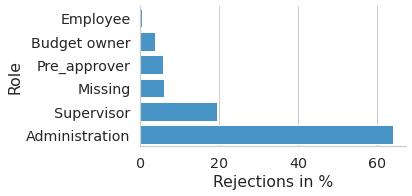

In [8]:
bar_plot(rejection_details, '04_rejection_rate_DD')

**International Declarations**

In [9]:
rejections = get_rejections(int_dec_log)

In [10]:
rejection_details = get_rejections_per_role(rejections)

Role              Rejections 
-----------------------------
Pre_approver               82
Budget owner               40
Director                    4
Employee                    5
Supervisor                123
Missing                   100
Administration           1519
-----------------------------
Total                    1873


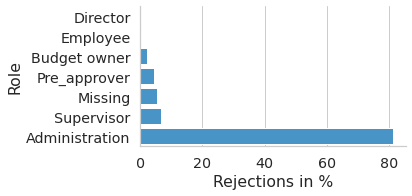

In [11]:
bar_plot(rejection_details, '04_rejection_rate_ID')

#### Inspect declarations that were rejected by the director

In [23]:
trace = int_dec_log[0]
print(trace.attributes['concept:name'])
events = list(map(lambda event: event['concept:name'], trace))
print(events)

declaration72590
['Start trip', 'End trip', 'Permit SUBMITTED by EMPLOYEE', 'Permit APPROVED by PRE_APPROVER', 'Permit FINAL_APPROVED by SUPERVISOR', 'Declaration SUBMITTED by EMPLOYEE', 'Declaration REJECTED by PRE_APPROVER', 'Declaration REJECTED by EMPLOYEE', 'Declaration SUBMITTED by EMPLOYEE', 'Declaration APPROVED by PRE_APPROVER', 'Declaration FINAL_APPROVED by SUPERVISOR', 'Request Payment', 'Payment Handled']


In [61]:
cases = []

print('{:<25s}{:^8s}{:^22s}'.format('Declaration', 'Amount', 'Req. Permit Budget'))
print('-'*55)

for trace in int_dec_log:
    events = list(map(lambda event: event['concept:name'], trace))
    if 'Declaration REJECTED by DIRECTOR' in events:
        print('{:<25s}{:>8.2f}{:>22.2f}'.format(trace.attributes['concept:name'], float(trace[0]['(case)_Amount']),  float(trace[0]['(case)_Permit_RequestedBudget'])))
        cases.append(trace.attributes['concept:name'])


Declaration               Amount   Req. Permit Budget  
-------------------------------------------------------
declaration74038          5397.81               6245.06
declaration75028          4000.10               2829.32
declaration78711             0.00                673.12
declaration27041           390.74               3041.26


The declaration 78711 was rejected by the director almost 9 months after the permit was submitted by the employee.

##### What is the average declared amount?

In [63]:
amounts = []
budgets = []

for trace in int_dec_log:
    amounts.append(float(trace[0]['(case)_Amount']))
    budgets.append(float(trace[0]['(case)_Permit_RequestedBudget']))

print('The average declared amount was {:0.2f}, with median of: {:0.2f}'.format(np.mean(amounts), np.median(amounts)))
print('The average requested budget was {:0.2f}, with median of: {:0.2f}'.format(np.mean(budgets), np.median(budgets)))

The average declared amount was 771.78, with median of: 512.84
The average requested budget was 1226.41, with median of: 923.08


## Question 2: 

Rejection Rate

In [37]:
print('International declarations')
df_int_dec = get_rejection_ratio(int_dec_log, 'international')

print()
print('Domestic declarations')
df_dom_dec = get_rejection_ratio(dom_dec_log, 'domestic')

International declarations
Role             | Approved | Rejected |Rejection rate
------------------------------------------------------
Director         |   252    |    4     |     1.56     
Administration   |   4944   |   1519   |    23.50     
Budget owner     |   1795   |    40    |     2.18     
Pre_approver     |   593    |    82    |    12.15     
Supervisor       |   6182   |   123    |     1.95     

Domestic declarations
Role             | Approved | Rejected |Rejection rate
------------------------------------------------------
Administration   |   8061   |   936    |    10.40     
Pre_approver     |   685    |    86    |    11.15     
Budget owner     |   2747   |    57    |     2.03     
Supervisor       |   9999   |   286    |     2.78     


In [60]:
df = pd.concat([df_dom_dec,df_int_dec])
df

,Role,Declaration Type,Rate
0,Budget owner,domestic,2.032810
1,Pre approver,domestic,11.154345
2,Administration,domestic,10.403468
3,Supervisor,domestic,2.780749
0,Supervisor,international,1.950833
1,Administration,international,23.503017
2,Director,international,1.562500
3,Budget owner,international,2.179837
4,Pre approver,international,12.148148


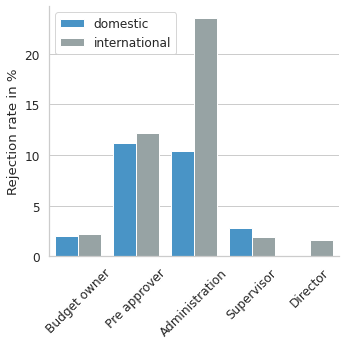

In [96]:
colors=["#3498db", "#95a5a6"]

sb.set(style="whitegrid", font_scale=1.1)
ax = sb.catplot(x='Role', y='Rate', hue='Declaration Type', data=df, 
                kind='bar', orient="v", legend=False, legend_out=False, palette=colors)
ax.set_xticklabels(rotation=45)
ax.set(xlabel='', ylabel='Rejection rate in %')


plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
# plt.savefig('04_rejection_rate_roles.pdf')

## Question 3:

In [79]:
get_never_approved(dom_dec_log)
get_never_approved(int_dec_log)

In total, 419 (4.05 perc.) applications were never approved.
In total, 21 (0.33 perc.) applications were never approved.
